In [ ]:
import zipfile
import os
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import os
import glob
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


# Implementation

## DataLoader

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, cache_in_memory=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Transform to be applied to each image.
            cache_in_memory (bool): If True, load all images into memory during initialization.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.cache_in_memory = cache_in_memory
        
        # List all image file paths in the folder (adjust extensions as needed)
        self.image_paths = [
            os.path.join(root_dir, file)
            for file in os.listdir(root_dir)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]
        
        # Optional: cache all images in memory for faster access (only if dataset is small)
        if self.cache_in_memory:
            print("Caching images into memory...")
            self.cache = []
            for path in self.image_paths:
                image = Image.open(path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                self.cache.append(image)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if self.cache_in_memory:
            return self.cache[idx]
        else:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image

## GAN

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3, feature_map_size=32):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: latent vector Z, shape: (latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            # State: (feature_map_size*8) x 4 x 4
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            # State: (feature_map_size*4) x 8 x 8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            # State: (feature_map_size*2) x 16 x 16
            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            # State: (feature_map_size) x 32 x 32
            nn.ConvTranspose2d(feature_map_size, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_map_size=32):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: 128x128 image
            nn.Conv2d(img_channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.AdaptiveAvgPool2d(1),  # Average pool to (1,1)
            nn.Sigmoid()  # Output: probability in [0, 1]
        )

    def forward(self, x):
        return self.net(x)

In [8]:
#!pip install torchsummary
from torchsummary import summary

## Hyperparameters and Transforms

In [12]:
latent_dim = 100
batch_size = 1024
num_epochs = 150
image_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
gen = Generator(latent_dim=latent_dim).to(device)
disc = Discriminator().to(device)
print("Generator Summary:")
summary(gen, (latent_dim, 1, 1))

print("\nDiscriminator Summary:")
summary(disc, (3, image_size, image_size))

Generator Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          32,768
      BatchNorm2d-11           [-1, 32, 32, 32]              64
             ReLU-12           [-1, 32, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           1,536
             Tanh-14

## Training loop

In [ ]:
def train_gan(data_dir, num_epochs=num_epochs, batch_size=batch_size, latent_dim=latent_dim, device=device, dest_path=None):
    # Prepare dataset and dataloader (uses recursive image loading)
    dataset = ImageDataset(root_dir=data_dir, transform=transform, cache_in_memory=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, 
                            pin_memory=True, persistent_workers=True, prefetch_factor=2)

    # Initialize models
    generator = Generator(latent_dim=latent_dim).to(device)
    discriminator = Discriminator().to(device)

    # If multiple GPUs are available, wrap models with DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        generator = nn.DataParallel(generator)
        discriminator = nn.DataParallel(discriminator)

    # Loss and optimizers
    criterion = nn.BCELoss()
    optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    print("Starting Training...")
    for epoch in range(num_epochs):
        for i, real_images in enumerate(dataloader):
            real_images = real_images.to(device)
            curr_batch_size = real_images.size(0)

            # Create labels
            real_labels = torch.full((curr_batch_size,), 1.0, dtype=torch.float, device=device)
            fake_labels = torch.full((curr_batch_size,), 0.0, dtype=torch.float, device=device)

            # ---------------------------
            # Train Discriminator
            # ---------------------------
            discriminator.zero_grad()
            # Train on real images
            output_real = discriminator(real_images).view(-1)
            loss_real = criterion(output_real, real_labels)
            loss_real.backward()

            # Train on fake images generated by the generator
            noise = torch.randn(curr_batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach()).view(-1)
            loss_fake = criterion(output_fake, fake_labels)
            loss_fake.backward()
            optimizerD.step()

            # ---------------------------
            # Train Generator
            # ---------------------------
            generator.zero_grad()
            output_for_gen = discriminator(fake_images).view(-1)
            loss_gen = criterion(output_for_gen, real_labels)
            loss_gen.backward()
            optimizerG.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {(loss_real+loss_fake).item():.4f}, Loss G: {loss_gen.item():.4f}")

    # Save final model
    torch.save(generator.state_dict(), 'generator_final.pth')
    torch.save(discriminator.state_dict(), 'discriminator_final.pth')

    print("Training Complete!")
    return generator, discriminator

In [ ]:
def train_gan(data_dir, num_epochs=num_epochs, batch_size=batch_size, latent_dim=latent_dim, device=device, dest_path=None, cache_in_memory=False):
    # Prepare dataset and dataloader (uses recursive image loading)
    dataset = ImageDataset(root_dir=data_dir, transform=transform, cache_in_memory=cache_in_memory)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, 
                            pin_memory=True, persistent_workers=True)

    # Initialize models
    generator = Generator(latent_dim=latent_dim).to(device)
    discriminator = Discriminator().to(device)

    # If multiple GPUs are available, wrap models with DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        generator = nn.DataParallel(generator)
        discriminator = nn.DataParallel(discriminator)

    # Loss and optimizers
    criterion = nn.BCELoss()
    optimizerG = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
    optimizerD = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

    print("Starting Training...")
    for epoch in range(num_epochs):
        epoch_loss_D = 0.0
        epoch_loss_G = 0.0
        epoch_acc_D = 0.0
        epoch_acc_G = 0.0
        batches = 0
        
        for i, real_images in enumerate(dataloader):
            batches += 1
            real_images = real_images.to(device)
            curr_batch_size = real_images.size(0)

            # Create labels
            real_labels = torch.full((curr_batch_size,), 1.0, dtype=torch.float, device=device)
            fake_labels = torch.full((curr_batch_size,), 0.0, dtype=torch.float, device=device)

            ## ---------------------------
            # Train Discriminator
            ## ---------------------------
            
            discriminator.zero_grad()
            output_real = discriminator(real_images).view(-1)
            loss_real = criterion(output_real, real_labels)
            loss_real.backward()

            acc_real = (output_real > 0.5).float().mean()
            noise = torch.randn(curr_batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach()).view(-1)
            loss_fake = criterion(output_fake, fake_labels)
            loss_fake.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
            optimizerD.step()
            acc_fake = (output_fake < 0.5).float().mean()

            d_accuracy = (acc_real + acc_fake) / 2.0

            ## ---------------------------
            # Train Generator
            ## ---------------------------
            generator.zero_grad()
            noise = torch.randn(curr_batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)  
            output_for_gen = discriminator(fake_images).view(-1)
            loss_gen = criterion(output_for_gen, real_labels)
            loss_gen.backward()
            optimizerG.step()
        
            g_accuracy = (output_for_gen > 0.5).float().mean()
            
            epoch_loss_D += (loss_real.item() + loss_fake.item())
            epoch_loss_G += loss_gen.item()
            epoch_acc_D += d_accuracy.item()
            epoch_acc_G += g_accuracy.item()

        avg_loss_D = epoch_loss_D / batches
        avg_loss_G = epoch_loss_G / batches
        avg_acc_D = epoch_acc_D / batches
        avg_acc_G = epoch_acc_G / batches
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss D: {avg_loss_D:.4f}, Loss G: {avg_loss_G:.4f} | "
              f"Acc D: {avg_acc_D*100:.2f}%, Acc G: {avg_acc_G*100:.2f}%")

    # Save final model
    torch.save(generator.state_dict(), 'generator_final.pth')
    torch.save(discriminator.state_dict(), 'discriminator_final.pth')

    print("Training Complete!")
    return


## Train

In [15]:
data_dir = '/kaggle/input/wikiart-subset/wikiart'
train_gan(data_dir=data_dir, num_epochs=num_epochs, batch_size=batch_size, latent_dim=latent_dim, device=device, cache_in_memory=True)

Caching images into memory...
Using 2 GPUs
Starting Training...
Epoch [1/150] Loss D: 1.1333, Loss G: 5.8529 | Acc D: 77.70%, Acc G: 0.13%
Epoch [2/150] Loss D: 1.2295, Loss G: 3.4746 | Acc D: 72.06%, Acc G: 4.28%
Epoch [3/150] Loss D: 1.1000, Loss G: 3.5451 | Acc D: 73.85%, Acc G: 3.64%
Epoch [4/150] Loss D: 1.2217, Loss G: 3.4353 | Acc D: 72.99%, Acc G: 5.54%
Epoch [5/150] Loss D: 1.1168, Loss G: 2.9591 | Acc D: 72.92%, Acc G: 6.23%
Epoch [6/150] Loss D: 1.2175, Loss G: 3.0173 | Acc D: 70.11%, Acc G: 8.35%
Epoch [7/150] Loss D: 0.9689, Loss G: 3.7846 | Acc D: 77.19%, Acc G: 2.86%
Epoch [8/150] Loss D: 1.0331, Loss G: 3.7027 | Acc D: 74.61%, Acc G: 3.03%
Epoch [9/150] Loss D: 1.0081, Loss G: 3.5833 | Acc D: 73.72%, Acc G: 1.01%
Epoch [10/150] Loss D: 1.0253, Loss G: 3.3341 | Acc D: 73.52%, Acc G: 3.13%
Epoch [11/150] Loss D: 0.9013, Loss G: 3.5612 | Acc D: 78.64%, Acc G: 2.64%
Epoch [12/150] Loss D: 1.0880, Loss G: 3.4712 | Acc D: 72.77%, Acc G: 5.10%
Epoch [13/150] Loss D: 0.9808, Lo

## Inference

In [ ]:
def generate_artwork(generator, latent_dim=latent_dim, device=device, num_images=1):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        # Rescale images from [-1, 1] to [0, 1]
        fake_images = fake_images * 0.5 + 0.5
    return fake_images.detach().permute(0, 2, 3, 1).cpu().numpy()

In [27]:
generator = Generator(latent_dim=latent_dim)
generator = nn.DataParallel(generator)
generator.load_state_dict(torch.load("generator_final.pth", map_location=device, weights_only=True))
generator.to(device)
im = generate_artwork(generator, num_images=9)

In [28]:
im.shape

(9, 64, 64, 3)

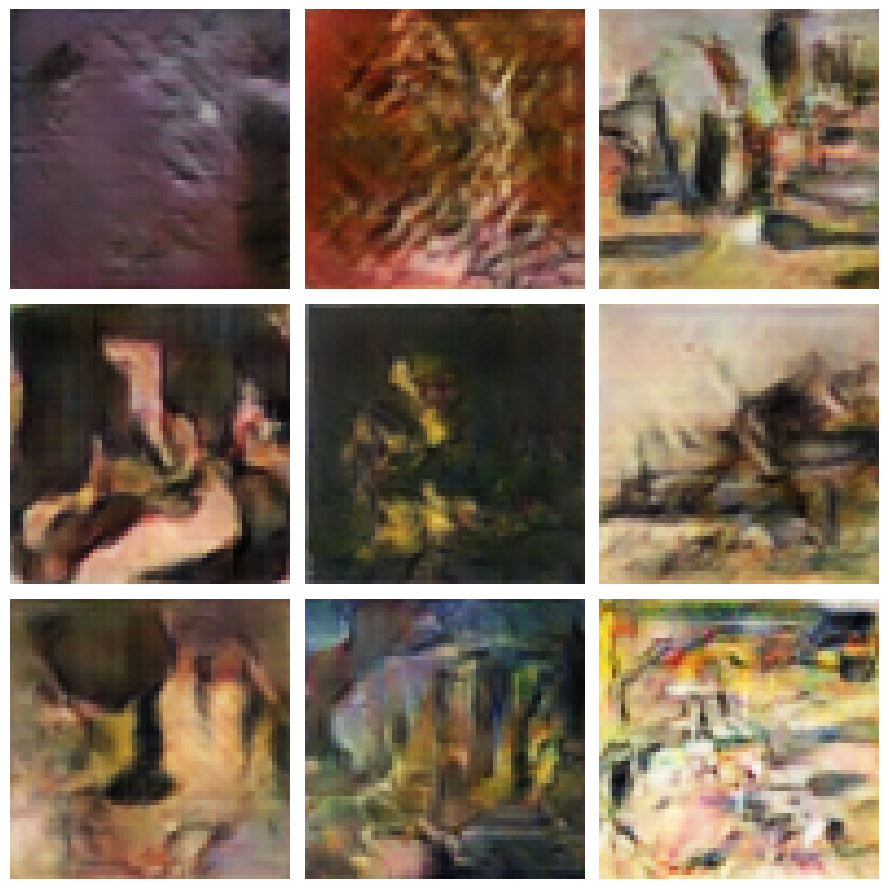

In [29]:
import matplotlib.pyplot as plt
num_images = im.shape[0]
cols = 3
rows = num_images // cols
if num_images % cols != 0:
    rows += 1

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for i in range(num_images):
    axes[i].imshow(im[i])
    axes[i].axis('off')  # Hide axis ticks

# Turn off any remaining subplots if there are extra spaces in the grid
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()